# Statistics on the output data. 

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import lizard
import subprocess as sub
from pylibsrcml import srcml
import os
import re 
import xml.etree.ElementTree as et 
import warnings
from sqlite3 import connect
from argparse import ArgumentParser
from configparser import ConfigParser
import yaml
from pathlib import Path
import random
from tabulate import tabulate

warnings.filterwarnings("ignore")


database = '../data/IoTcode_contiki_rasp_filtered_full.db'
conn= connect(database)

random.seed(0)

dfp = pd.read_sql_query("SELECT * FROM project", con=conn)
dfs = pd.read_sql_query("SELECT * FROM statement", con=conn)
dff = pd.read_sql_query("SELECT * FROM function", con=conn)

if not os.path.exists("figure"):
    os.mkdir("figure")
dfs.columns

Index(['file', 'line', 'column', 'defaultlevel', 'level', 'category', 'name',
       'msg', 'note', 'cwe', 'context', 'helpuri', 'severity', 'tool', 'type',
       'project'],
      dtype='object')

In [34]:
dfplt = dfs[['category', 'name', 'cwe']].groupby(['category', 'name', 'cwe'], group_keys=False).size().reset_index(name='count')
fig = px.sunburst(dfplt, path=['category', 'name', 'cwe'], values='count')
# fig.write_image("figure/vul_statistics.pdf")
fig.show()
dfplt.head()

,category,name,cwe,count
0,-,integerOverflow,CWE-190,1
1,access,umask,CWE-732,63
2,buffer,CopyMemory,CWE-120,2
3,buffer,bcopy,CWE-120,2
4,buffer,char,CWE-119!/CWE-120,11310


# Top 10 vulnerabilities

In [35]:
df_top10 = dfplt.sort_values(by=['count'], ascending=False).head(10)
print(tabulate(df_top10, headers='keys', tablefmt='psql'))
df_top10.to_latex("../result/top10.tex", index=False, caption="Top 10 CWEs in IoT code")

+----+------------+---------+------------------+---------+
|    | category   | name    | cwe              |   count |
|----+------------+---------+------------------+---------|
| 15 | buffer     | memcpy  | CWE-120          |   14139 |
|  4 | buffer     | char    | CWE-119!/CWE-120 |   11310 |
| 20 | buffer     | sprintf | CWE-120          |    4577 |
| 25 | buffer     | strlen  | CWE-126          |    2883 |
| 17 | buffer     | read    | CWE-120, CWE-20  |    1765 |
| 24 | buffer     | strcpy  | CWE-120          |    1277 |
| 47 | misc       | open    | CWE-362          |     873 |
| 50 | race       | access  | CWE-362/CWE-367! |     847 |
| 27 | buffer     | strncpy | CWE-120          |     534 |
| 65 | shell      | system  | CWE-78           |     322 |
+----+------------+---------+------------------+---------+


In [36]:
print(list(dfplt.name))

['integerOverflow', 'umask', 'CopyMemory', 'bcopy', 'char', 'equal', 'fgetc', 'fscanf', 'fscanf', 'getc', 'getchar', 'getenv', 'getopt', 'getopt_long', 'gets', 'memcpy', 'mismatch', 'read', 'realpath', 'scanf', 'sprintf', 'sscanf', 'sscanf', 'strcat', 'strcpy', 'strlen', 'strncat', 'strncpy', 'vfscanf', 'vsprintf', 'vsscanf', 'wchar_t', 'crypt', 'fprintf', 'printf', 'snprintf', 'sprintf', 'syslog', 'vfprintf', 'vprintf', 'vsnprintf', 'vsprintf', 'memalign', 'atoi', 'atol', 'chroot', 'fopen', 'open', 'ulimit', 'usleep', 'access', 'chmod', 'chown', 'readlink', 'vfork', 'random', 'setstate', 'srand', 'srandom', 'execl', 'execle', 'execlp', 'execv', 'execvp', 'popen', 'system', 'mkstemp', 'tmpfile']


# Analysis of IoTvulCode tool generated output for feeding non-vul statements:


<AxesSubplot: >

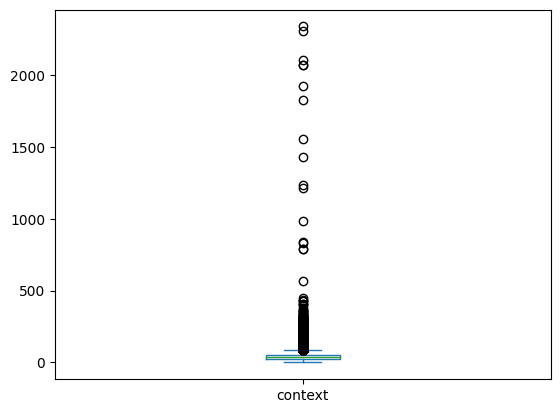

In [37]:
dfs.context.str.len().sort_values(ascending=False).reset_index(drop=True).plot(kind='box')

<AxesSubplot: >

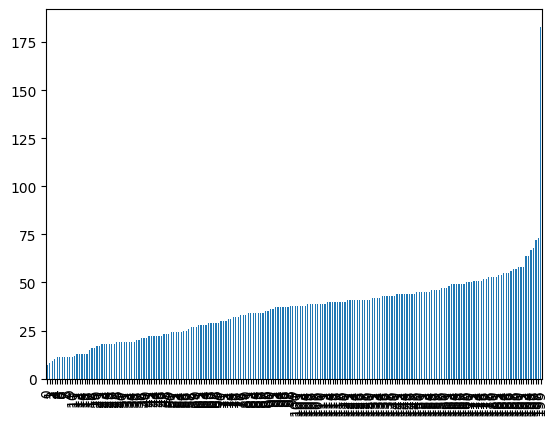

In [38]:
# dfs.context.head(200).str.len().plot(kind='bar')
pd.Series(sorted(list(dfs.context.head(200).str.len()))).plot(kind='bar')

<AxesSubplot: ylabel='Frequency'>

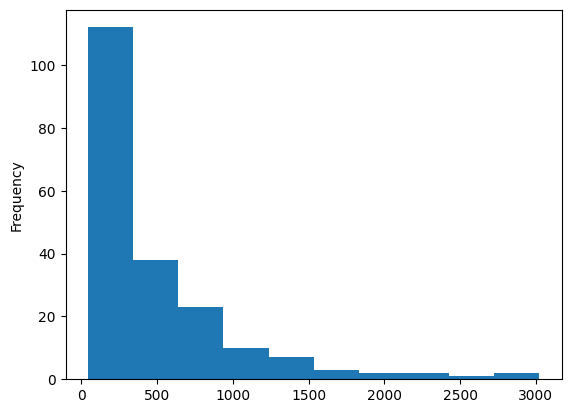

In [39]:
# pd.Series([len(x) for x in dfs.context.head(2000) if len(x)>100]).plot(kind='hist')
# pd.Series([len(x) for x in dfs.context.head(200) if len(x)<10]).plot(kind='hist', xlabel='#chars', ylabel='#statements', xlim=[0, 80])
pd.Series([len(x) for x in dff.code.head(200) if len(x)>10]).plot.hist(xlabel='#chars', ylabel='#statements')

In [41]:
def filter_unusual_statements(statements, min_len, max_len, df):
    """" 
    # https://peps.python.org/pep-0007/
    # https://www.python.org/dev/peps/pep-0007/ 

    """
    filtered_statements = []
    for statement in statements:
        if len(statement) >= min_len and len(statement) <= max_len:
            filtered_statements.append(statement)
   
    # take size of the vul statements as basis
    df = pd.Series(statements)   
    df = df.str.len()
    
    stat_sizes =  list(df[df.between(max_len, min_len)].reset_index(drop=True))
    
    sample_size = 5 if len(stat_sizes)>5 else len(stat_sizes)-1
    stat_sizes = random.sample(set(stat_sizes), sample_size)
    return stat_sizes


# standard variables:
max_len = 79  #TODO: double check pep standards

# TODO: check min_len as well, otherwise the below code unnessesarily checks one extra condition 
# because there is no any statement/fun with len below that. 
# for min_len (eg, 7 characters)
min_len = dfs.context.str.len().sort_values(ascending=False).reset_index(drop=True).min()


lines = dff.code[0].splitlines()
stat_sizes = filter_unusual_statements(lines, max_len, min_len, dfs)
stat_sizes

[49, 30, 0, 43, 17]

In [42]:
# df_dnn = pd.read_csv('../data/iDetect_refine/DNN_Binary.csv')
# df_conti = pd.read_csv('../data/contiki-master_Binary.csv')
# df_rasp = pd.read_csv('../data/raspberry_metrics.csv')
# df_rasp_flaw = pd.read_csv('../data/raspberry_flaw.csv')

# print('Shape of DNN data: ', df_dnn.shape)
# print('Shape of contiki: ', df_conti.shape)
# print('Shape of raspberry: ', df_rasp.shape)
# print('Shape of raspberry flaws: ', df_rasp_flaw.shape)

# dfcon = dfcon.rename(columns={'context': 'code'})
# dfcon.to_csv('../data/contiki-master_Binary.csv', index=False)

# Convert hyperparameters list to latex table format

In [43]:
def hyperpara2latex(yaml_file):
    """
    load the yaml file and return a dictionary
    """
    config = {}
    cols = ['hyperparameter', 'value']
    
    ext = Path(yaml_file).suffix.replace('.', '') 
    
    with open(yaml_file, "r") as stream:
        try:
            config = yaml.safe_load(stream)
            df = pd.DataFrame([config['dnn']]).T.reset_index()
            print(df.to_latex(index=False, 
                    header=cols, 
                    #   column_format='|l|l|', 
                    label='Hyperparameter Settings', 
                    caption='Hyperparameter Settings'))
        except yaml.YAMLError as exc:
            print(exc)

config = hyperpara2latex('../config.yaml')

\begin{table}
\centering
\caption{Hyperparameter Settings}
\label{Hyperparameter Settings}
\begin{tabular}{ll}
\toprule
hyperparameter &                           value \\
\midrule
        epochs &                              50 \\
         batch &                             128 \\
  input\_length &                             150 \\
     input\_dim &                             150 \\
    output\_dim &                              32 \\
            lr &                            1e-4 \\
      patience &                             100 \\
     optimizer &                            adam \\
        l2\_reg &                            1e-4 \\
       dropout &                             0.0 \\
 recur\_dropout &                             0.0 \\
        beta\_1 &                             0.9 \\
        beta\_2 &                           0.999 \\
       epsilon &                           1e-08 \\
         decay &                             0.0 \\
       verbose &                

In [44]:
len(dff.drop_duplicates(subset=['file', 'long_name', 'start_line', 'end_line', 'cwe'], keep='last').reset_index(drop=True))

456440

In [45]:
projects = list(dfs.project.unique())

for project in projects:
    print(project)
    df = dfs[dfs.project == project]
    print(df.shape)
    print(df.cwe.value_counts())
    print(df.category.value_counts())
    print('----------------------')

data/projects/linux-rpi-6.1.y
(1441750, 16)
Benign              1401461
CWE-120               20552
CWE-119!/CWE-120      10953
CWE-126                2872
CWE-120, CWE-20        1980
CWE-362                1084
CWE-362/CWE-367!        844
CWE-134                 790
CWE-78                  368
CWE-327                 305
CWE-190                 213
CWE-807, CWE-20          75
CWE-676                  64
CWE-732                  63
CWE-120/CWE-785!         55
CWE-377                  37
CWE-362, CWE-20          29
CWE-250, CWE-22           5
Name: cwe, dtype: int64
buffer      36487
misc         1058
race          904
format        790
shell         368
integer       212
crypto        210
random         95
access         63
obsolete       54
tmpfile        37
free           10
-               1
Name: category, dtype: int64
----------------------
data/projects/contiki-2.4
(8334, 16)
Benign              7340
CWE-119!/CWE-120     504
CWE-120              312
CWE-126               83
CWE-3

## Create a latex table from the statistics of projects

In [98]:
def save_latex(df, file):
    """
    save the dataframe as latex table
    """
    styler = df.style
    # styler.applymap_index(lambda v: "font-weight: bold;", axis="index")
    styler.applymap_index(lambda v: "font-weight: bold;", axis="columns")
    res = styler.to_latex(convert_css=True, column_format='|l|l|r|')

    with open(file, 'w') as f:
        f.write(res)
    return res

# make class binary type benign/vulnerable
dfs.loc[dfs.cwe!="Benign", 'cwe'] = "Vulnerable"
dfs['project'] = dfs.project.str.split('/').str[-1]

prj_stat = dfs.groupby(['project', 'cwe']).size().reset_index(name='count')
prj_s = prj_stat.groupby(['project', 'cwe']).sum()

res = tabulate(save_latex(prj_s, '../paper/project_stat.tex'))
prj_s

count
project         cwe                
contiki-2.4     Benign         7340
                Vulnerable      994
linux-rpi-6.1.y Benign      1401461
                Vulnerable    40289

In [108]:
prj_sflat = prj_s.reset_index()
prj_sflat = prj_sflat.pivot(index='project', columns='cwe', values='count')
prj_sflat.reset_index().to_latex('../paper/project_stat_flat.tex', index=False)

In [126]:
# make class binary type benign/vulnerable
dff.loc[dfs.cwe!="Benign", 'cwe'] = "Vulnerable"

prj_ff = dff.groupby(['project', 'cwe']).size().reset_index(name='count')
prj_f = prj_ff.groupby(['cwe']).sum().sort_values(by='count', ascending=False).reset_index()
prj_f = prj_f[prj_f.cwe != 'Benign'].head(10)
print(prj_f.to_latex(index=False, caption='Top 10 CWEs', label='Top 10 CWEs'))

\begin{table}
\centering
\caption{Top 10 CWEs}
\label{Top 10 CWEs}
\begin{tabular}{lr}
\toprule
                            cwe &  count \\
\midrule
                        CWE-120 &  18799 \\
                    CWE-unknown &   6663 \\
               CWE-119!/CWE-120 &   5616 \\
                        CWE-457 &   2518 \\
                        CWE-126 &   1987 \\
                        CWE-190 &   1696 \\
['CWE-120', 'CWE-119!/CWE-120'] &   1322 \\
                CWE-120, CWE-20 &   1157 \\
                        CWE-362 &    691 \\
         ['CWE-120', 'CWE-126'] &    608 \\
\bottomrule
\end{tabular}
\end{table}



In [110]:
prj_s = dfs.groupby(['project', 'cwe']).size().reset_index(name='count')
prj_s = prj_s.groupby(['cwe']).sum()
prj_s

,count
cwe,
Benign,1408801
Vulnerable,41283


# Show the description of the function-level data

In [48]:
df_describe = dff.drop(
    labels=['top_nesting_level', 'fan_in', 'fan_out', 'general_fan_out', 'content', 'long_name', 'fun_name', 'full_parameters', 'code'],
    axis=1, 
    errors='ignore').describe().T

In [49]:
print('#functions: ', dff.shape[0])
df_describe = df_describe.reset_index().rename(columns={'index': 'features'}).drop(labels=['count'], axis=1)
# The freq is the most common value’s frequency. The top is the most common value.
df_describe

#functions:  456440


,features,unique,top,freq
0,cyclomatic_complexity,199,1,135614
1,nloc,513,4,37690
2,token_count,2090,17,4784
3,name,429371,main,630
4,start_line,11701,71,550
5,end_line,11752,121,552
6,file,17619,data/projects/linux-rpi-6.1.y/drivers/infiniba...,602
7,isVul,1,1,456440
8,cwe,366,Benign,411053
9,project,2,data/projects/linux-rpi-6.1.y,454096


In [60]:
print(df_describe[~df_describe.features.isin(['file'])].to_latex(
    index=False, 
    column_format='rrrrr', 
    label='Function Statistics', 
    caption='Function Statistics')
    )

\begin{table}
\centering
\caption{Function Statistics}
\label{Function Statistics}
\begin{tabular}{rrrrr}
\toprule
             features & unique &                           top &   freq \\
\midrule
cyclomatic\_complexity &    199 &                             1 & 135614 \\
                 nloc &    513 &                             4 &  37690 \\
          token\_count &   2090 &                            17 &   4784 \\
                 name & 429371 &                          main &    630 \\
           start\_line &  11701 &                            71 &    550 \\
             end\_line &  11752 &                           121 &    552 \\
                isVul &      1 &                             1 & 456440 \\
                  cwe &    366 &                        Benign & 411053 \\
              project &      2 & data/projects/linux-rpi-6.1.y & 454096 \\
\bottomrule
\end{tabular}
\end{table}



In [64]:
dfs.tool.value_counts()

sampling      1408801
FlawFinder      41282
CppCheck            1
Name: tool, dtype: int64

In [70]:
dfs.context.nunique()

1450084